# Recovering exact parameters

This additionally randomly scales each dim of the true distribution by a random factor.

In [1]:
# These are needed so the git commands below take immediate effect.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.optim import ClippedAdam
from torch.distributions import kl_divergence
from matplotlib import pyplot

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}

In [3]:
class Model:
    def __init__(self, dim, rank):
        scale = dist.Uniform(-1, 1).sample([dim])
        self.loc = dist.Laplace(0, 1).sample([dim]) * scale
        self.cov_factor = torch.randn(dim, rank) * scale.unsqueeze(-1)
        self.cov_diag = dist.Exponential(1).sample([dim]) * scale ** 2
        
    def get_prior(self):
        return dist.LowRankMultivariateNormal(
            self.loc, self.cov_factor, self.cov_diag)
        
    def __call__(self):
        pyro.sample("z", self.get_prior())

In [4]:
def train(dim, rank):
    pyro.clear_param_store()
    pyro.set_rng_seed(123456789)
    model = Model(dim, rank)
    guide = AutoLowRankMultivariateNormal(model, rank=rank, init_scale=0.01)
    optim = ClippedAdam({"lr": 0.01})
    elbo = Trace_ELBO()
    svi = SVI(model, guide, optim, elbo)
    losses = []
    kls = []
    for step in range(2001):
        loss = svi.step() / dim
        with torch.no_grad():
            kl = kl_divergence(guide.get_posterior(), model.get_prior()).item()
        losses.append(loss)
        kls.append(kl)
        if step % 200 == 0:
            print("step {: >4} loss = {:0.8g}, kl = {:0.8g}".format(step, loss, kl))
    return losses, kls

In [5]:
results = {}

In [6]:
!(cd ~/pyro ; git checkout dev)

Switched to branch 'dev'
Your branch is up-to-date with 'origin/dev'.


In [7]:
results["dev-10-3"] = train(10, 3)
results["dev-100-10"] = train(100, 10)
results["dev-1000-30"] = train(1000, 30)

step    0 loss = 3.3455641, kl = 32.24334
step  200 loss = 1.2713729, kl = 13.904194
step  400 loss = 0.86986427, kl = 7.5116091
step  600 loss = 0.2826375, kl = 3.6179752
step  800 loss = 0.17885742, kl = 2.3518867
step 1000 loss = 0.097022533, kl = 1.7633843
step 1200 loss = 0.070202255, kl = 2.7291231
step 1400 loss = 0.095473385, kl = 1.6881938
step 1600 loss = 0.12460318, kl = 1.5717587
step 1800 loss = -0.020017433, kl = 1.9356976
step 2000 loss = 0.0020191193, kl = 1.544107
step    0 loss = 5.2007701, kl = 522.93622
step  200 loss = 2.886463, kl = 346.23334
step  400 loss = 3.6905435, kl = 284.44382
step  600 loss = 1.2876534, kl = 196.55347
step  800 loss = 1.2316965, kl = 187.1308
step 1000 loss = 7.040547, kl = 209.63245
step 1200 loss = 6.6873783, kl = 287.38611
step 1400 loss = 6.1152421, kl = 180.03107
step 1600 loss = 4.783884, kl = 261.8775
step 1800 loss = 0.62214333, kl = 144.80649
step 2000 loss = 0.66917107, kl = 193.60791
step    0 loss = 8.0748398, kl = 24321.102
s

In [8]:
!(cd ~/pyro ; git checkout auto-lowrank-mvn-reparam)

Switched to branch 'auto-lowrank-mvn-reparam'


In [9]:
results["new-10-3"] = train(10, 3)
results["new-100-10"] = train(100, 10)
results["new-1000-30"] = train(1000, 30)

step    0 loss = 3.1639334, kl = 33.287361
step  200 loss = 1.0289583, kl = 11.053724
step  400 loss = 0.58218231, kl = 3.0666637
step  600 loss = -0.10988369, kl = 2.1157222
step  800 loss = 0.17880917, kl = 1.1853657
step 1000 loss = 0.091785622, kl = 1.0202165
step 1200 loss = 0.045892048, kl = 0.88692474
step 1400 loss = 0.074937916, kl = 0.76003313
step 1600 loss = 0.036169624, kl = 0.82236099
step 1800 loss = 0.43137608, kl = 0.86405611
step 2000 loss = -0.062020683, kl = 0.60068274
step    0 loss = 5.036095, kl = 487.35449
step  200 loss = 1.1683476, kl = 116.43599
step  400 loss = 0.30484756, kl = 34.442108
step  600 loss = 0.23243557, kl = 23.849113
step  800 loss = 0.2108094, kl = 19.625092
step 1000 loss = 0.13243721, kl = 18.25666
step 1200 loss = 0.23423737, kl = 18.159393
step 1400 loss = 0.12507042, kl = 15.014023
step 1600 loss = 0.10679527, kl = 13.907284
step 1800 loss = 0.049334259, kl = 14.950226
step 2000 loss = 0.14462482, kl = 13.564575
step    0 loss = 7.6743677

In [10]:
def plot(dim, rank):
    pyplot.figure(figsize=(9,3))
    for name, (losses, kls) in sorted(results.items()):
        if name.endswith(f"-{dim}-{rank}"):
            pyplot.plot(kls, label=name)
    pyplot.title(f"dim={dim} rank={rank}")
    pyplot.ylabel('kl(q,p)')
    pyplot.yscale('log')
    pyplot.xlabel('svi step')
    pyplot.legend()
    pyplot.tight_layout()

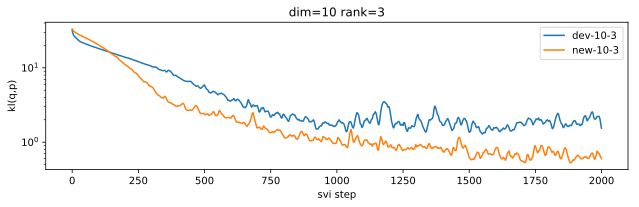

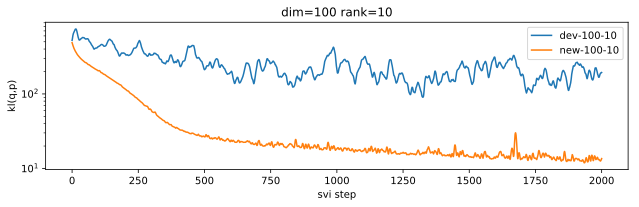

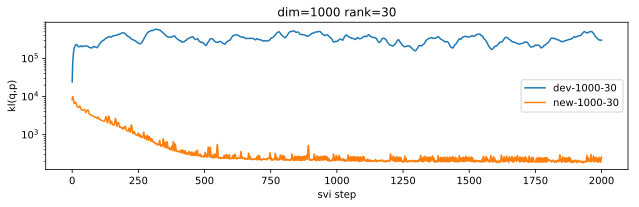

In [11]:
plot(10, 3)
plot(100, 10)
plot(1000, 30)